In [57]:
import sqlite3 as sql
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from datetime import timedelta
from statsmodels.tsa import stattools
from statsmodels.graphics import tsaplots
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima
import itertools
import sklearn.metrics as metrics
from time import time

## Datenbank einbinden

In [58]:
connection = sql.connect("gcs_gh_10012022.db")
query_params = ['''SELECT * FROM s1_temp''']
df_temp1 = pd.read_sql_query(query_params[0], connection, parse_dates=['timestamp'], index_col=['timestamp'])

In [59]:
df_temp1 = df_temp1.sort_index().loc['2021-02-17':'2021-02-28']

## Ausreißer behandeln
https://medium.com/@krzysztofdrelczuk/time-series-anomaly-detection-with-python-example-a92ef262f09a
https://github.com/kdrelczuk/medium/blob/master/anomalies_local.py#L37

In [60]:
column = df_temp1['value']

k = int(len(column) * (0.16/100))
N = len(column)
print("Window size: ", k)
print("Datapoints: ", N)

time = np.arange(0,N)
column = column.to_numpy()

get_bands = lambda df_temp1 : (np.mean(df_temp1) + 3*np.std(df_temp1), np.mean(df_temp1) - 3*np.std(df_temp1))

Window size:  5
Datapoints:  3274


In [61]:
bands = [get_bands(column[range(0 if i - k < 0 else i-k ,i + k if i + k < N else N)]) for i in range(0,N)]
upper, lower = zip(*bands)

In [62]:
anomalies = (df_temp1['value'] > upper) | (df_temp1['value'] < lower)

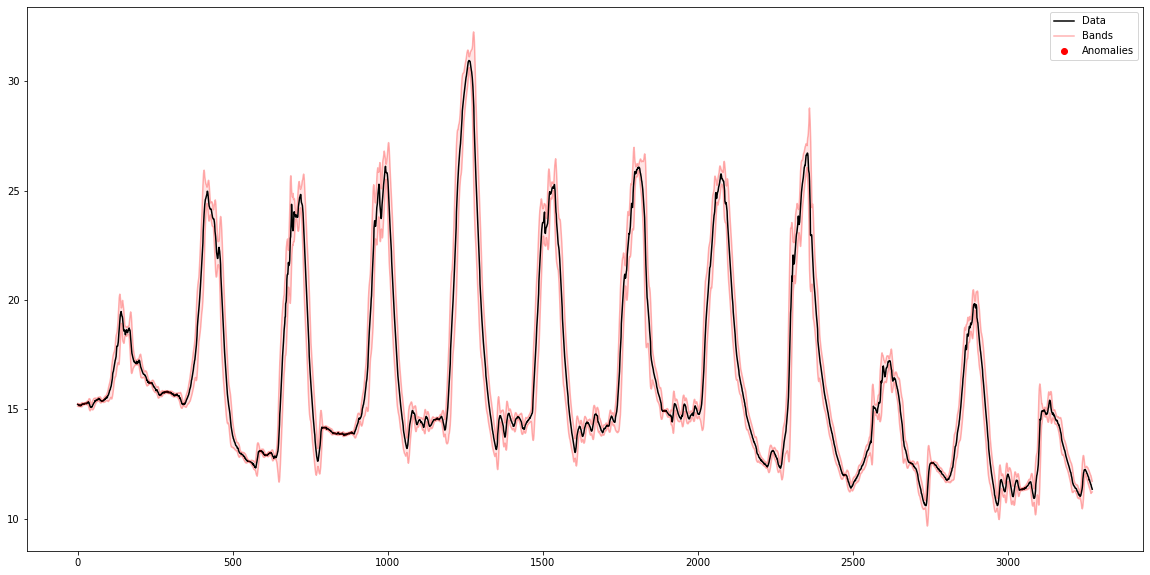

In [63]:
plt.figure(figsize=(20,10))
plt.plot(time,column,'k',label='Data')
plt.plot(time,upper,'r-',label='Bands',alpha=0.3)
plt.plot(time,lower,'r-',alpha=0.3)

plt.plot(time[anomalies],column[anomalies],'ro',label='Anomalies')
plt.fill_between(time, upper, lower,facecolor='red',alpha=0.1)
plt.legend()

In [64]:
anomalies = anomalies.index[anomalies]
print(anomalies)

DatetimeIndex([], dtype='datetime64[ns]', name='timestamp', freq=None)


In [65]:
df_temp1['value'].sort_index().loc[anomalies].replace(np.NaN, inplace=True)
print(df_temp1['value'].isna().any())

False


## Datenlücken, duplizierte Indices behandeln

In [66]:
# prüfen ob doppelte Index-Werte (Timestamp) vorhanden 
print('TS has duplicates:', df_temp1.index.has_duplicates)
print('TS has NaN:', df_temp1['value'].isna().any())

# dopplte Index-Werte der Ausgangszeitreihe anzeigen 
df_temp1_duplicates = df_temp1[df_temp1.index.duplicated()]
print(df_temp1_duplicates)
print()

# Zeitreihe nach Behandlung der Indizes und Lücken durch Zusammenfassen anzeigen
df_temp1_5min = df_temp1.resample('5Min').mean()
print('TS 5min Intervals has duplicates:', df_temp1_5min.index.has_duplicates)
print('TS 5min Intervals has NaN:', df_temp1_5min['value'].isna().any())

## Zeiträume sehen, in denen keine Daten vorhanden sind und durch das Zusammenfassen zu NaN werden
# print(df_temp1_5min.head(60))
# print(df_temp1.head(60))

TS has duplicates: True
TS has NaN: False
                        value
timestamp                    
2021-02-17 17:11:56  17.17060
2021-02-17 17:11:56  17.17060
2021-02-17 17:11:56  17.10117
2021-02-25 16:35:40  22.95186
2021-02-25 16:35:40  22.97856
2021-02-25 16:35:41  22.97856

TS 5min Intervals has duplicates: False
TS 5min Intervals has NaN: True


In [67]:
df_temp1_5min = df_temp1_5min.fillna(method='ffill')
print('TS 5min Intervals has NaN:', df_temp1_5min['value'].isna().any())

TS 5min Intervals has NaN: False


## Daten zusammenfassen

In [68]:
df_temp1_hourly = df_temp1_5min.resample('H').mean()

## Stationarität

### Prüfen der Stationarität

[Text(0.5, 0, 'time in days'),
 Text(0, 0.5, 'temp in °C'),
 Text(0.5, 1.0, 'Daily mean GWH Temperature')]

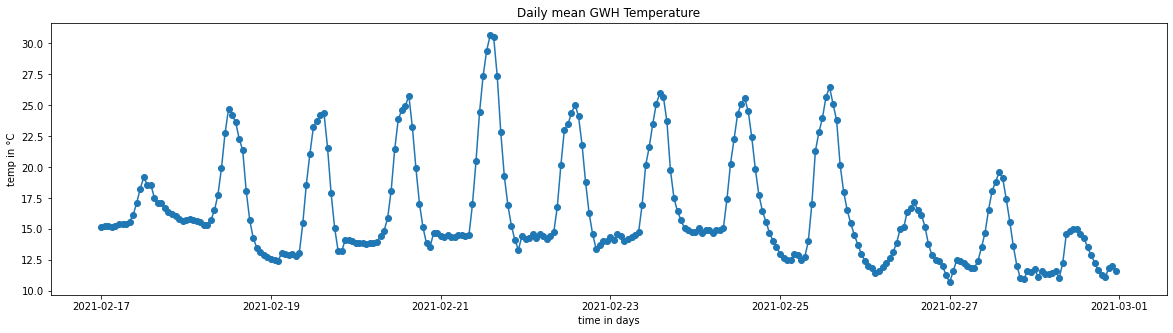

In [69]:
fig, ax = plt.subplots(figsize=(20, 5))
ax.scatter(df_temp1_hourly.index, df_temp1_hourly['value'])
ax.plot(df_temp1_hourly.index, df_temp1_hourly['value'])
ax.set(xlabel="time in days",
       ylabel="temp in °C",                                                                                                                             
       title="Daily mean GWH Temperature")

In [70]:
series = df_temp1_hourly['value'].values
result = adfuller(series)

print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -1.6504779547344282
p-value: 0.4567911690852536
Critial Values:
   1%, -3.4547128138328875
Critial Values:
   5%, -2.8722649771800155
Critial Values:
   10%, -2.5724850011573914


Da (p-Wert) 0.33 > (p-Wert Schwelle) 0.05 , wird die Nullhyppthese angenommen. Die Zeitreihe ist nicht stationär. <br>

In [89]:
df_temp1_hourly = df_temp1_hourly.asfreq(pd.infer_freq(df_temp1_hourly.index))
decomp_result = seasonal_decompose(df_temp1_hourly['value'], model='additive')

trend = decomp_result.trend
periodic = decomp_result.seasonal
residual = decomp_result.resid

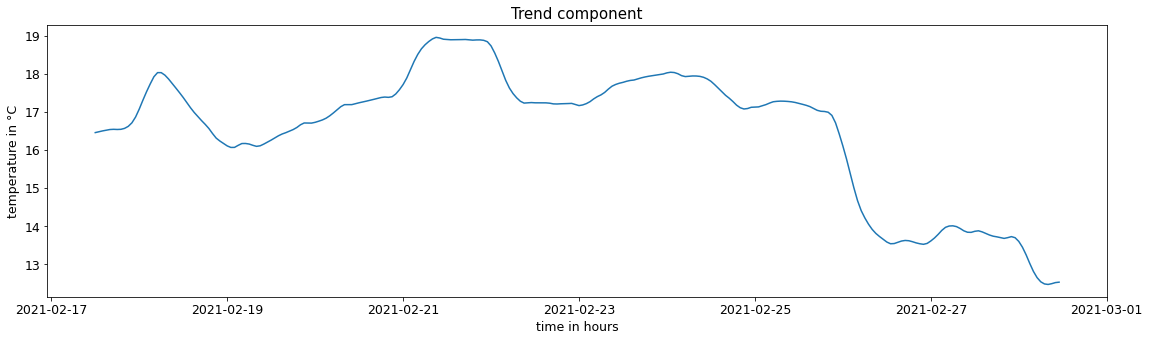

In [90]:
plt.figure(figsize=(19,5))
plt.title('Trend component')
plt.xlabel("time in hours")
plt.ylabel("temperature in °C")

plt.plot(trend)

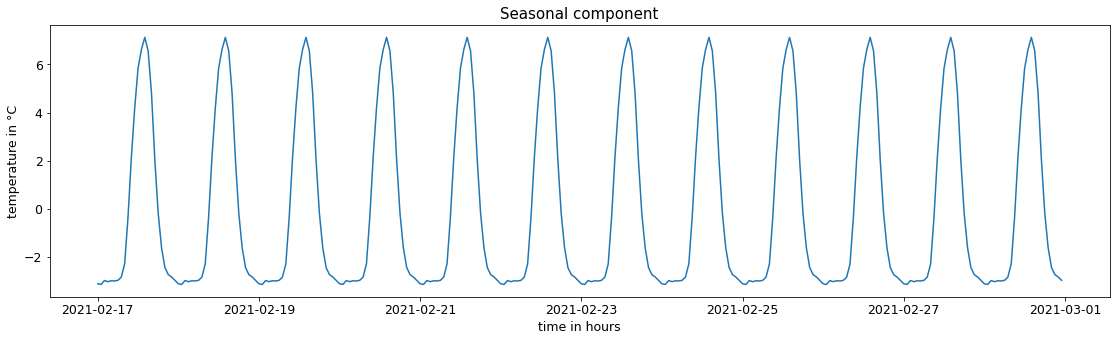

In [91]:
plt.figure(figsize=(19,5))
plt.title('Seasonal component')
plt.xlabel("time in hours")
plt.ylabel("temperature in °C") 

plt.plot(periodic)

## Stationarität herstellen

### Saisonalität entfernen

Die Zeitreihe ist nach dem ADF-Test zwar stationär, allerdings scheint noch eine Saisonalität vorzuliegen. Da angenommen wird, dass sich die Temperatur im Tagesrhythmus verändert, wird die Differenz von 24 gebildet. d.h. die Zeitreihe wird mit ihrer, um 24h verschobenen, Zeitreihe abgezogen. Um die Varianzen zu reduzieren wird das Ergbnis nochmal um 1 differenziert.

[Text(0.5, 0, 'time in days'),
 Text(0, 0.5, 'temp in °C'),
 Text(0.5, 1.0, 'Detrended GWH Temperature')]

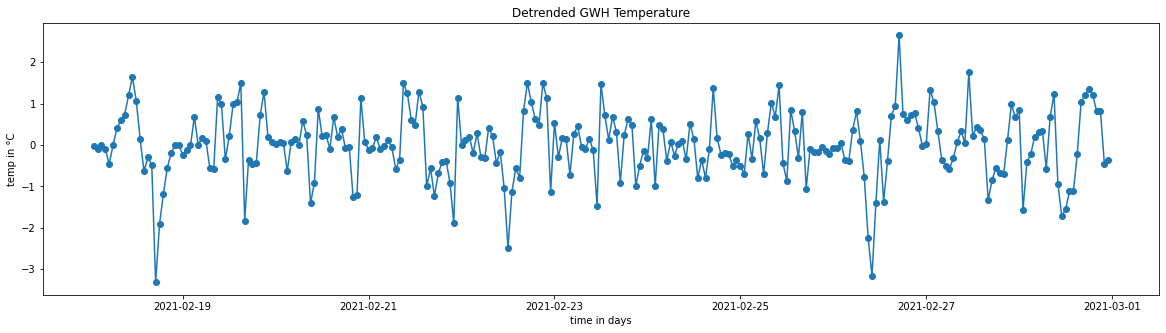

In [71]:
series_temp1_stationary_diff = df_temp1_hourly['value'].diff(periods=24)
series_temp1_stationary_diff = series_temp1_stationary_diff - series_temp1_stationary_diff.shift(1)
df_temp1_stationary = pd.DataFrame(series_temp1_stationary_diff)
df_temp1_stationary.columns.values[0] = "value"

fig, ax = plt.subplots(figsize=(20, 5))
ax.plot(df_temp1_stationary.index, df_temp1_stationary['value'])
ax.scatter(df_temp1_stationary.index, df_temp1_stationary['value'])
ax.set(xlabel="time in days",
       ylabel="temp in °C",
       title="Detrended GWH Temperature")

In [72]:
df_temp1_stationary = df_temp1_stationary.fillna(method='ffill').dropna()

series = df_temp1_stationary
result = adfuller(series, autolag='AIC')

print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -6.3169926802815235
p-value: 3.1328398920912434e-08
Critial Values:
   1%, -3.456780859712
Critial Values:
   5%, -2.8731715065600003
Critial Values:
   10%, -2.572968544


## Autokorrelation

### ACF

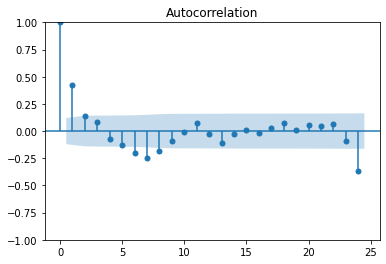

In [73]:
acf_result = stattools.acf(df_temp1_stationary)
acf_plot_temp1_hourly = tsaplots.plot_acf(df_temp1_stationary, lags=24)

### PACF

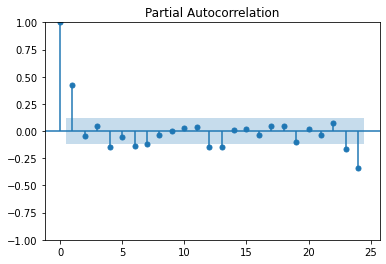

In [74]:
pacf_plot_temp1_hourly = tsaplots.plot_pacf(df_temp1_stationary,  method='ywm', lags=24)

## Daten splitten

In [75]:
# Frequenz der Zeitreihe wird festgelegt
df_temp1_modelling_data = df_temp1_hourly.asfreq(pd.infer_freq(df_temp1_hourly.index))

In [76]:
# Für die Evaluation: Training-Set, Testing-Set bilden
train_data = df_temp1_modelling_data.sort_index().loc['2021-02-17':'2021-02-25']
test_data = df_temp1_modelling_data.sort_index().loc['2021-02-26':'2021-02-28']

print(train_data)

                         value
timestamp                     
2021-02-17 00:00:00  15.195220
2021-02-17 01:00:00  15.242173
2021-02-17 02:00:00  15.289571
2021-02-17 03:00:00  15.202119
2021-02-17 04:00:00  15.264426
...                        ...
2021-02-25 19:00:00  16.543957
2021-02-25 20:00:00  15.482282
2021-02-25 21:00:00  14.563689
2021-02-25 22:00:00  13.765926
2021-02-25 23:00:00  13.027803

[216 rows x 1 columns]


In [77]:
# Prediction Start und Ende festlegen
pred_start = test_data.index[0]
pred_end =test_data.index[-1]

## AR(I)MA

### ARIMA(1,0,2)
* selbst geschätzt anhand ACF, PACF

Mean absolute error (MAE):  3.5475310177647454
Mean squared error (MSE):  16.206341478478095
Root Mean sqaured error (RMSE):  4.025710058918563


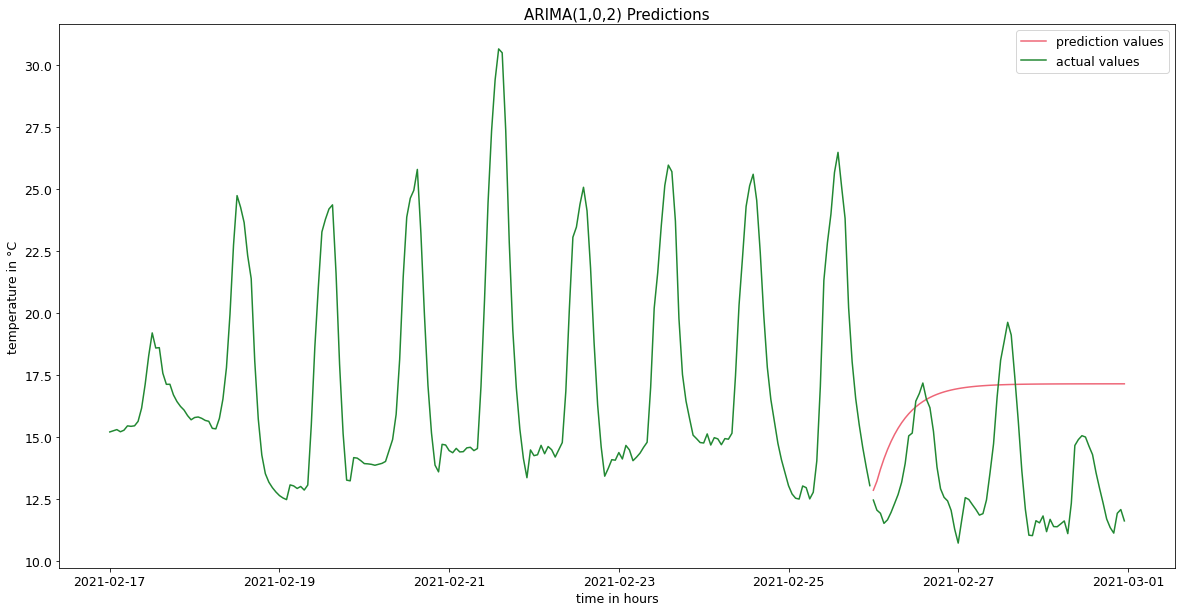

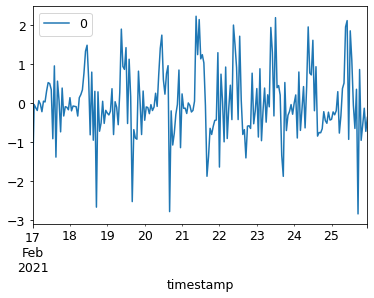

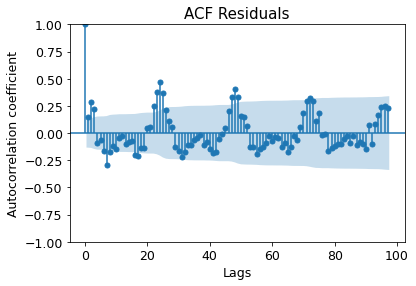

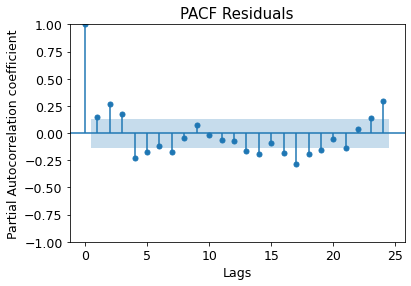

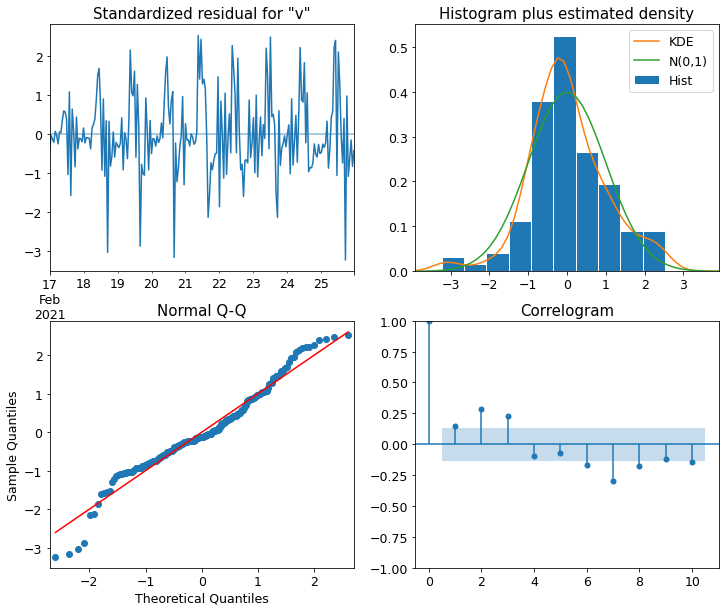

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  value   No. Observations:                  216
Model:                 ARIMA(1, 0, 2)   Log Likelihood                -281.378
Date:                Mon, 04 Jul 2022   AIC                            572.757
Time:                        08:43:34   BIC                            589.633
Sample:                    02-17-2021   HQIC                           579.575
                         - 02-25-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         17.1377      1.466     11.690      0.000      14.264      20.011
ar.L1          0.8773      0.037     23.717      0.000       0.805       0.950
ma.L1          0.9922      0.059     16.836      0.000       0.877       1.108
ma.L2          0.4444      0.065      6.827      0.000       0.317       0.572
sigma2         0.7775      0.067     11.530      0.000       0.645       0.910
===================================================================================
Ljung-Box (L1) (Q):                   4.86   Jarque-Bera (JB):                 9.69
Prob(Q):                              0.03   Prob(JB):                         0.01
Heteroskedasticity (H):               1.46   Skew:                             0.04
Prob(H) (two-sided):                  0.11   Kurtosis:                         4.04
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [88]:
model = ARIMA(train_data, order=(1,0,2))
model_fit = model.fit()

fcast = model_fit.get_prediction(start=pred_start, end=pred_end)
ts_p = fcast.predicted_mean
df_temp1['forecast'] = fcast
# ts_ci = fcast.conf_int()

plt.rcParams.update({'font.size': 12.5})
plt.figure(figsize=(20,10))
plt.title(label='ARIMA(1,0,2) Predictions')
plt.plot(ts_p, color='#EE6677', label='prediction values')
plt.plot(test_data, color='#228833', label='actual values')
plt.plot(train_data, color='#228833')
# plt.fill_between(ts_ci.index[1:],
#                 ts_ci.iloc[1:, 0],
#                 ts_ci.iloc[1:, 1], color='k', alpha=.2, label='prediction interval')
plt.xlabel("time in hours")
plt.ylabel("temperature in °C") 
plt.legend()

mae = metrics.mean_absolute_error(test_data, ts_p)
mse = metrics.mean_squared_error(test_data, ts_p)
rmse = np.sqrt(mse)

print("Mean absolute error (MAE): ", mae) 
print("Mean squared error (MSE): ", mse)
print("Root Mean sqaured error (RMSE): ", rmse)

residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
acf_plot_temp1_hourly = tsaplots.plot_acf(residuals, lags=97, title="ACF Residuals")
plt.xlabel("Lags")
plt.ylabel("Autocorrelation coefficient") 
pacf_plot_temp1_hourly = tsaplots.plot_pacf(residuals,  method='ywm', title="PACF Residuals")
plt.xlabel("Lags")
plt.ylabel("Partial Autocorrelation coefficient")

model_fit.plot_diagnostics(figsize=(12,10))
plt.show()

model_fit.summary()

## auto_arima

In [81]:
stepwise_fit = auto_arima(train_data,
                            test='adf',
                            m = 1,
                            d = None,
                            seasonal=False,
                            error_action='ignore',  # ignoriert Ordnungen, die nicht funktionieren
                            suppress_warnings=True,  # ignoriert Konvergenzwarnungen
                            stepwise=True)
stepwise_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  216
Model:               SARIMAX(2, 0, 0)   Log Likelihood                -250.359
Date:                Sun, 03 Jul 2022   AIC                            508.719
Time:                        21:42:54   BIC                            522.220
Sample:                             0   HQIC                           514.173
                                - 216                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      1.9435      0.252      7.702      0.000       1.449       2.438
ar.L1          1.7372      0.033     52.722      0.000       1.673       1.802
ar.L2         -0.8492      0.031    -27.518      0.000      -0.910      -0.789
sigma2         0.5819      0.058      9.966      0.000       0.467       0.696
===================================================================================
Ljung-Box (L1) (Q):                   1.32   Jarque-Bera (JB):                 2.63
Prob(Q):                              0.25   Prob(JB):                         0.27
Heteroskedasticity (H):               1.38   Skew:                             0.08
Prob(H) (two-sided):                  0.18   Kurtosis:                         3.52
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Mean absolute error (MAE):  4.107998883782677
Mean squared error (MSE):  20.625280946370555
Root Mean sqaured error (RMSE):  4.5415064622182975


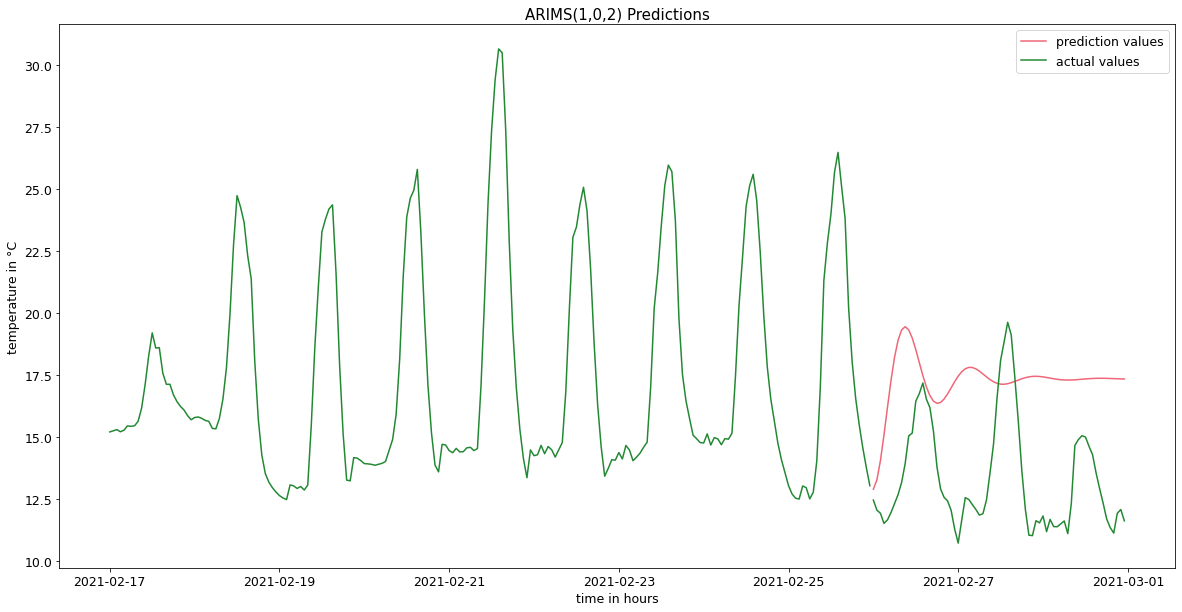

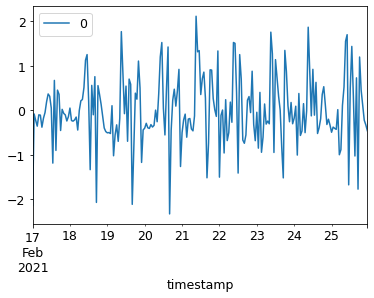

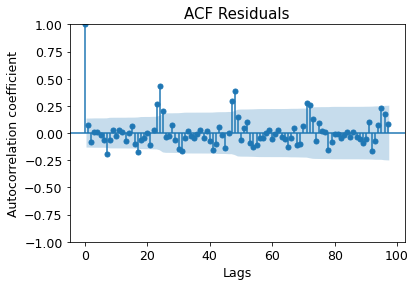

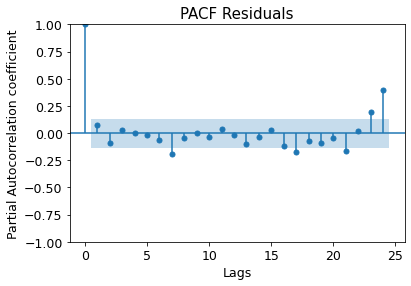

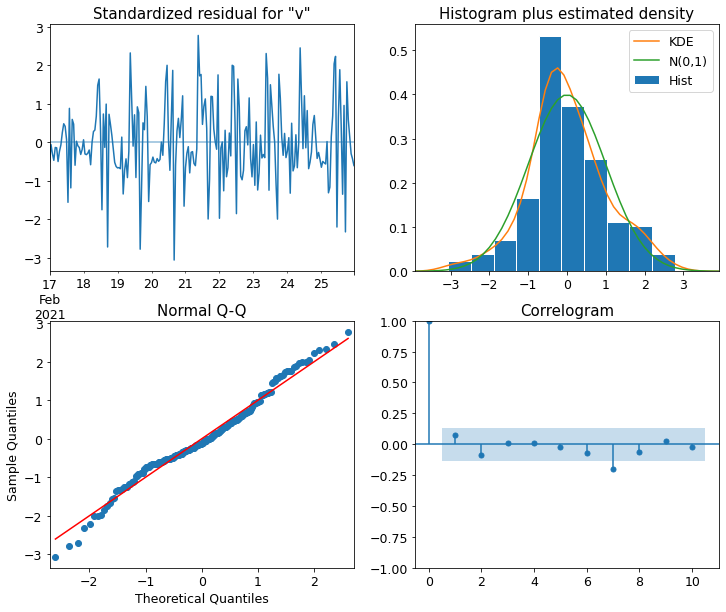

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  value   No. Observations:                  216
Model:                 ARIMA(2, 0, 0)   Log Likelihood                -250.359
Date:                Mon, 04 Jul 2022   AIC                            508.719
Time:                        08:43:06   BIC                            522.220
Sample:                    02-17-2021   HQIC                           514.173
                         - 02-25-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         17.3381      0.521     33.278      0.000      16.317      18.359
ar.L1          1.7372      0.033     52.722      0.000       1.673       1.802
ar.L2         -0.8493      0.031    -27.518      0.000      -0.910      -0.789
sigma2         0.5819      0.058      9.966      0.000       0.467       0.696
===================================================================================
Ljung-Box (L1) (Q):                   1.32   Jarque-Bera (JB):                 2.63
Prob(Q):                              0.25   Prob(JB):                         0.27
Heteroskedasticity (H):               1.38   Skew:                             0.08
Prob(H) (two-sided):                  0.18   Kurtosis:                         3.52
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [87]:
# Modell anpassen
model = ARIMA(train_data, order=(2,0,0))
model_fit = model.fit()

fcast = model_fit.get_prediction(start=pred_start, end=pred_end)
ts_p = fcast.predicted_mean
df_temp1['forecast'] = model_fit.predict(start=pred_start, end=pred_end)
# ts_ci = fcast.conf_int()

plt.rcParams.update({'font.size': 12.5})
plt.figure(figsize=(20,10))
plt.title(label='ARIMS(1,0,2) Predictions')
plt.plot(ts_p, color='#EE6677', label='prediction values')
plt.plot(test_data, color='#228833', label='actual values')
plt.plot(train_data, color='#228833')
# plt.fill_between(ts_ci.index[1:],
#                 ts_ci.iloc[1:, 0],
#                 ts_ci.iloc[1:, 1], color='k', alpha=.2, label='prediction interval')
plt.xlabel("time in hours")
plt.ylabel("temperature in °C") 
plt.legend()

mae = metrics.mean_absolute_error(test_data, ts_p)
mse = metrics.mean_squared_error(test_data, ts_p)
rmse = np.sqrt(mse)

print("Mean absolute error (MAE): ", mae) 
print("Mean squared error (MSE): ", mse)
print("Root Mean sqaured error (RMSE): ", rmse)

residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
acf_plot_temp1_hourly = tsaplots.plot_acf(residuals, lags=97, title="ACF Residuals")
plt.xlabel("Lags")
plt.ylabel("Autocorrelation coefficient") 
pacf_plot_temp1_hourly = tsaplots.plot_pacf(residuals,  method='ywm', title="PACF Residuals")
plt.xlabel("Lags")
plt.ylabel("Partial Autocorrelation coefficient")

model_fit.plot_diagnostics(figsize=(12,10))
plt.show()

model_fit.summary()

## Gridsearch

In [52]:
p = range(0,2)
d = {0}
q = range(0,3)
pdq = list(itertools.product(p,d,q)) # alle Kombis von p,d,q
combs = {}
aics = []

In [53]:
for combination in pdq:
    model = ARIMA(train_data, order=combination,
                  enforce_stationarity=True,
                  enforce_invertibility=True)
    model = model.fit()
    combs.update({model.aic : [combination]})
    aics.append(model.aic)

c:\users\miche\appdata\local\programs\python\python38-32\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\users\miche\appdata\local\programs\python\python38-32\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


In [54]:
best_aic = min(aics)
print('best aic is: ', round(best_aic, 3))
print(14*'==')
print ('ARIMA parameters: ',combs[best_aic][0])

best aic is:  572.757
ARIMA parameters:  (1, 0, 2)


In [ ]:
connection.close()